In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import sys
from copy import deepcopy
import itertools

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize
try:
    initialize(version_base=None, config_path="../sam2_logs/", job_name="predict_run")
except ValueError:
    pass

import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
import torch
from torch.amp import autocast
from torchvision.transforms import ToPILImage, Normalize, Resize
from torchmetrics.detection import PanopticQuality
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO, LABEL_PROJECTION_MAP
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from custom_model_builder import build_sam2former

/home/guests/tuna_gurbuz/prototype


In [3]:
model_size_dict = {
    # 'base': {
    #     'config': '04_28_00_50/config_resolved.yaml',
    #     'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/04_28_00_50/checkpoints/checkpoint_33.pt',
    #     },
    # 'base': {
    #     'config': '05_24_10_21/config_resolved.yaml',
    #     'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/05_24_10_21/checkpoints/checkpoint_34.pt',
    #     },
    'base': {
        'config': '06_17_16_27/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/06_17_16_27/checkpoints/checkpoint_60.pt',
        },
}

# Model
model_size = 'base'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
amp_type = torch.bfloat16 if device == 'cuda' else torch.float16
submodel, object_labels, _, loss = build_sam2former(config, ck, device=device)
print(device)

OmegaConf resolved successfully


Frequency file exists. Using weights from frequency file
Using log loss weighting...
Using default weights
cuda


In [4]:
for ii in range(6):
    before = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    # print("before", before)
    print(torch.all(before == 0))
sd = torch.load(ck, map_location="cpu", weights_only=True)["model"]
missing_keys, unexpected_keys = submodel.load_state_dict(sd, strict=False)
for ii in range(6):
    after = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    # print("after", after)
    print(torch.all(after == 0))

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [5]:
# Dataset
len_video = 7
input_image_size = 256
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# revert_mean=[-.485/.229, -.456/.224, -.406/.225]
# revert_std=[1/.229, 1/.224, 1/.225]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('val',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           get_seg_mask=True,
                           shuffle=shuffle,)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 002_PKA!



4311it [00:02, 1945.19it/s]


Interpolated frames are not included! The number of frames in the cameras are not equal!
Loading the take 007_TKA!



3466it [00:01, 2028.32it/s]


Loading the take 009_TKA!



3276it [00:01, 1651.15it/s]

Interpolated frames are not included! The number of frames in the cameras are not equal!
Lenght of the dataset! 2090


In [6]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False
# sample_idx = 950
# sample_idx = 2000
# sample_idx = 1250
# # sample_idx = 3993
sample_idx = 500
test_loader = test_dataset.get_loader()
flag_iter = False

# Run the model
with torch.no_grad():
    submodel.eval()
    if flag_iter:
        batch = next(itertools.islice(test_loader, sample_idx, None))
    else:
        batch = [test_dataset[i] for i in range(sample_idx * batch_size, (sample_idx+1) * batch_size) if i < len(test_dataset)]
        batch = collate_fn(batch, 'val')
    batched_video_data_val = batch.to(device)
    # batch_seg_mask_gt = batch[1]  # List of PIL Image for debug
    masks_val = batch.masks.to(device)
    with autocast(device_type=device, dtype=amp_type):
        all_frame_outputs_val = submodel(batched_video_data_val)

In [7]:
# Adapt to new changes (View)
all_frame_outputs_val = all_frame_outputs_val[0]

# Concatenate frame outputs as batch
for i in range(len(all_frame_outputs_val)):
    if i == 0:
        all_masks = all_frame_outputs_val[i]['pred_masks_high_res']
        all_labels = all_frame_outputs_val[i]['pred_logits']
    else:
        all_masks = torch.cat((all_masks, all_frame_outputs_val[i]['pred_masks_high_res']), dim=0)
        all_labels = torch.cat((all_labels, all_frame_outputs_val[i]['pred_logits']), dim=0)

# Convert mask prediction logits to binary masks
binary_pred_masks = all_masks.sigmoid() > 0.5
binary_pred_masks = binary_pred_masks.cpu().numpy()

# Convert class logits to class predictions
pred_logits = all_labels.type(torch.float32).softmax(-1).cpu().numpy()
pred_class = pred_logits.argmax(-1)

B, N, H, W = binary_pred_masks.shape  # Size with padding
gt_labels = batched_video_data_val.metadata.unique_objects_identifier[:,:,1]

In [8]:
# import json
# dump_dict = {k: v.cpu().type(torch.float32).numpy().tolist() for k,v in all_frame_outputs_val[0].items() if k != 'aux_outputs'}
# with open('../temp/predictions.json', 'w') as f:
#     json.dump(dump_dict, f)

In [9]:
pred_class

array([[15, 13,  6,  7,  0,  6, 14,  6,  8,  9,  2, 10,  3,  6,  1,  5,
        12,  4,  6,  6,  6,  6, 11],
       [15, 13,  6,  7,  0,  6, 14,  6,  8,  9,  2, 10,  3,  6,  1,  5,
        12,  4,  6,  6,  6,  6, 11],
       [15, 13,  6,  7,  0,  6, 14,  6,  8,  9,  2, 10,  3,  6,  1,  5,
        12,  4,  6,  6,  6,  6, 11],
       [15, 13,  6,  7,  0,  6, 14,  6,  8,  9,  2, 10,  3,  6,  1,  5,
        12,  4,  6,  6,  6,  6, 11],
       [15, 13,  6,  7,  0,  6, 14,  6,  8,  9,  2, 10,  3,  6,  1,  5,
        12,  4,  6,  6,  6,  6, 11],
       [15, 13,  6,  7,  0,  6, 14,  6,  8,  9,  2, 10,  3,  6,  1,  5,
        12,  4,  6,  6,  6,  6, 11],
       [15, 13,  6,  7,  0,  6, 14,  6,  8,  9,  2, 10,  3,  6,  1,  5,
        12,  4,  6,  6,  6,  6, 11]])

In [10]:
def get_color_map():
    color_map = {}
    for k, v in LABEL_PROJECTION_MAP.items():
        if k > 7 and v['label'] == 6:
            continue
        r, g, b = v['color']
        color_map[v['label']] = (r,g,b)
    # color_map = ListedColormap(color_map)
    return color_map

# Get color map
color_map = get_color_map()

In [11]:
# Prepare segmentation mask and RGB mask with color encoding
pred_seg_class_mask = np.ones((B, 1, H, W), dtype=np.int8) * 16  # 16 is the background class
pred_rgb_mask = np.zeros((B, H, W, 3), dtype=np.uint8)
for _b_idx, (_b_binary_pred_masks, _b_pred_class) in enumerate(zip(binary_pred_masks, pred_class)):
    for mask, class_id in zip(_b_binary_pred_masks, _b_pred_class):
        pos = np.where(mask == True)
        if len(pos[0]) > 0:
            pred_seg_class_mask[_b_idx, 0, pos[0], pos[1]] = class_id
            pred_rgb_mask[_b_idx, pos[0], pos[1], :] = color_map[class_id]
        else:
            continue

In [12]:
batched_video_data_val.obj_to_frame_idx.shape, batched_video_data_val.obj_to_frame_idx[:,:,0], masks_val.shape

(torch.Size([7, 23, 2]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
         [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
         [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]],
        device='cuda:0', dtype=torch.int32),
 torch.Size([7, 23, 256, 256]))

In [13]:
gt_seg_class_mask = np.ones((B, 1, H, W), dtype=np.int8) * 16  # 16 is the background class
gt_rgb_mask = np.zeros((B, H, W, 3), dtype=np.uint8)
for batch_idx in range(B):
    pos = batched_video_data_val.obj_to_frame_idx[:,:,0] == batch_idx  # The objects in the batch are mixed
    gt_mask = masks_val[pos, :, :].cpu().numpy()  # Get the GT masks in the batch
    gt_class_id = gt_labels[pos].cpu().numpy()  # Get the GT class id in the batch
    for mask, class_id in zip(gt_mask, gt_class_id):
        pos = np.where(mask == True)
        if len(pos[0]) > 0:
            gt_seg_class_mask[batch_idx, 0, pos[0], pos[1]] = class_id
            gt_rgb_mask[batch_idx, pos[0], pos[1], :] = color_map[class_id]
        else:
            continue

In [14]:
# Initialize lists for masks
pred_rgb_mask_list_azure = []
pred_seg_class_mask_list_azure = []
gt_rgb_mask_list_azure = []
gt_seg_class_mask_list_azure = []

pred_rgb_mask_list_sim = []  # Auxillary lists for now
pred_seg_class_mask_list_sim = []  # Auxillary lists for now
gt_rgb_mask_list_sim = []  # Auxillary lists for now
gt_seg_class_mask_list_sim = []  # Auxillary lists for now

# Revert the padding
for batch_idx in range(B):
    # Load the corresponding rgb image to look for padding 
    img = batched_video_data_val.img_batch[batch_idx][0].permute(1,2,0).cpu().numpy()
    
    # Check if the image is black (0,0,0) along the height dimension
    is_black_row = (img[:,:,0] <= 0)  # Check along width and channels
    pos_padding = np.where(is_black_row == False)
    start = pos_padding[0][0]
    end = pos_padding[0][-1]
    
    # Slice the predictions and ground truth masks
    if start == 32:
        pred_rgb_mask_list_azure.append(pred_rgb_mask[batch_idx, start:end+1, :, :])
        pred_seg_class_mask_list_azure.append(pred_seg_class_mask[batch_idx, 0:1, start:end+1, :])
        gt_rgb_mask_list_azure.append(gt_rgb_mask[batch_idx, start:end+1, :, :])
        gt_seg_class_mask_list_azure.append(gt_seg_class_mask[batch_idx, 0:1, start:end+1, :])
    elif start == 0:
        pass
    else:
        raise ValueError("Padding not found in the image")

# Concatenate the masks
pred_rgb_mask = np.array(pred_rgb_mask_list_azure)
pred_seg_class_mask = np.array(pred_seg_class_mask_list_azure)
gt_rgb_mask = np.array(gt_rgb_mask_list_azure)
gt_seg_class_mask = np.array(gt_seg_class_mask_list_azure)

### Color encoded segmentation masks and label encoded segmentation masks

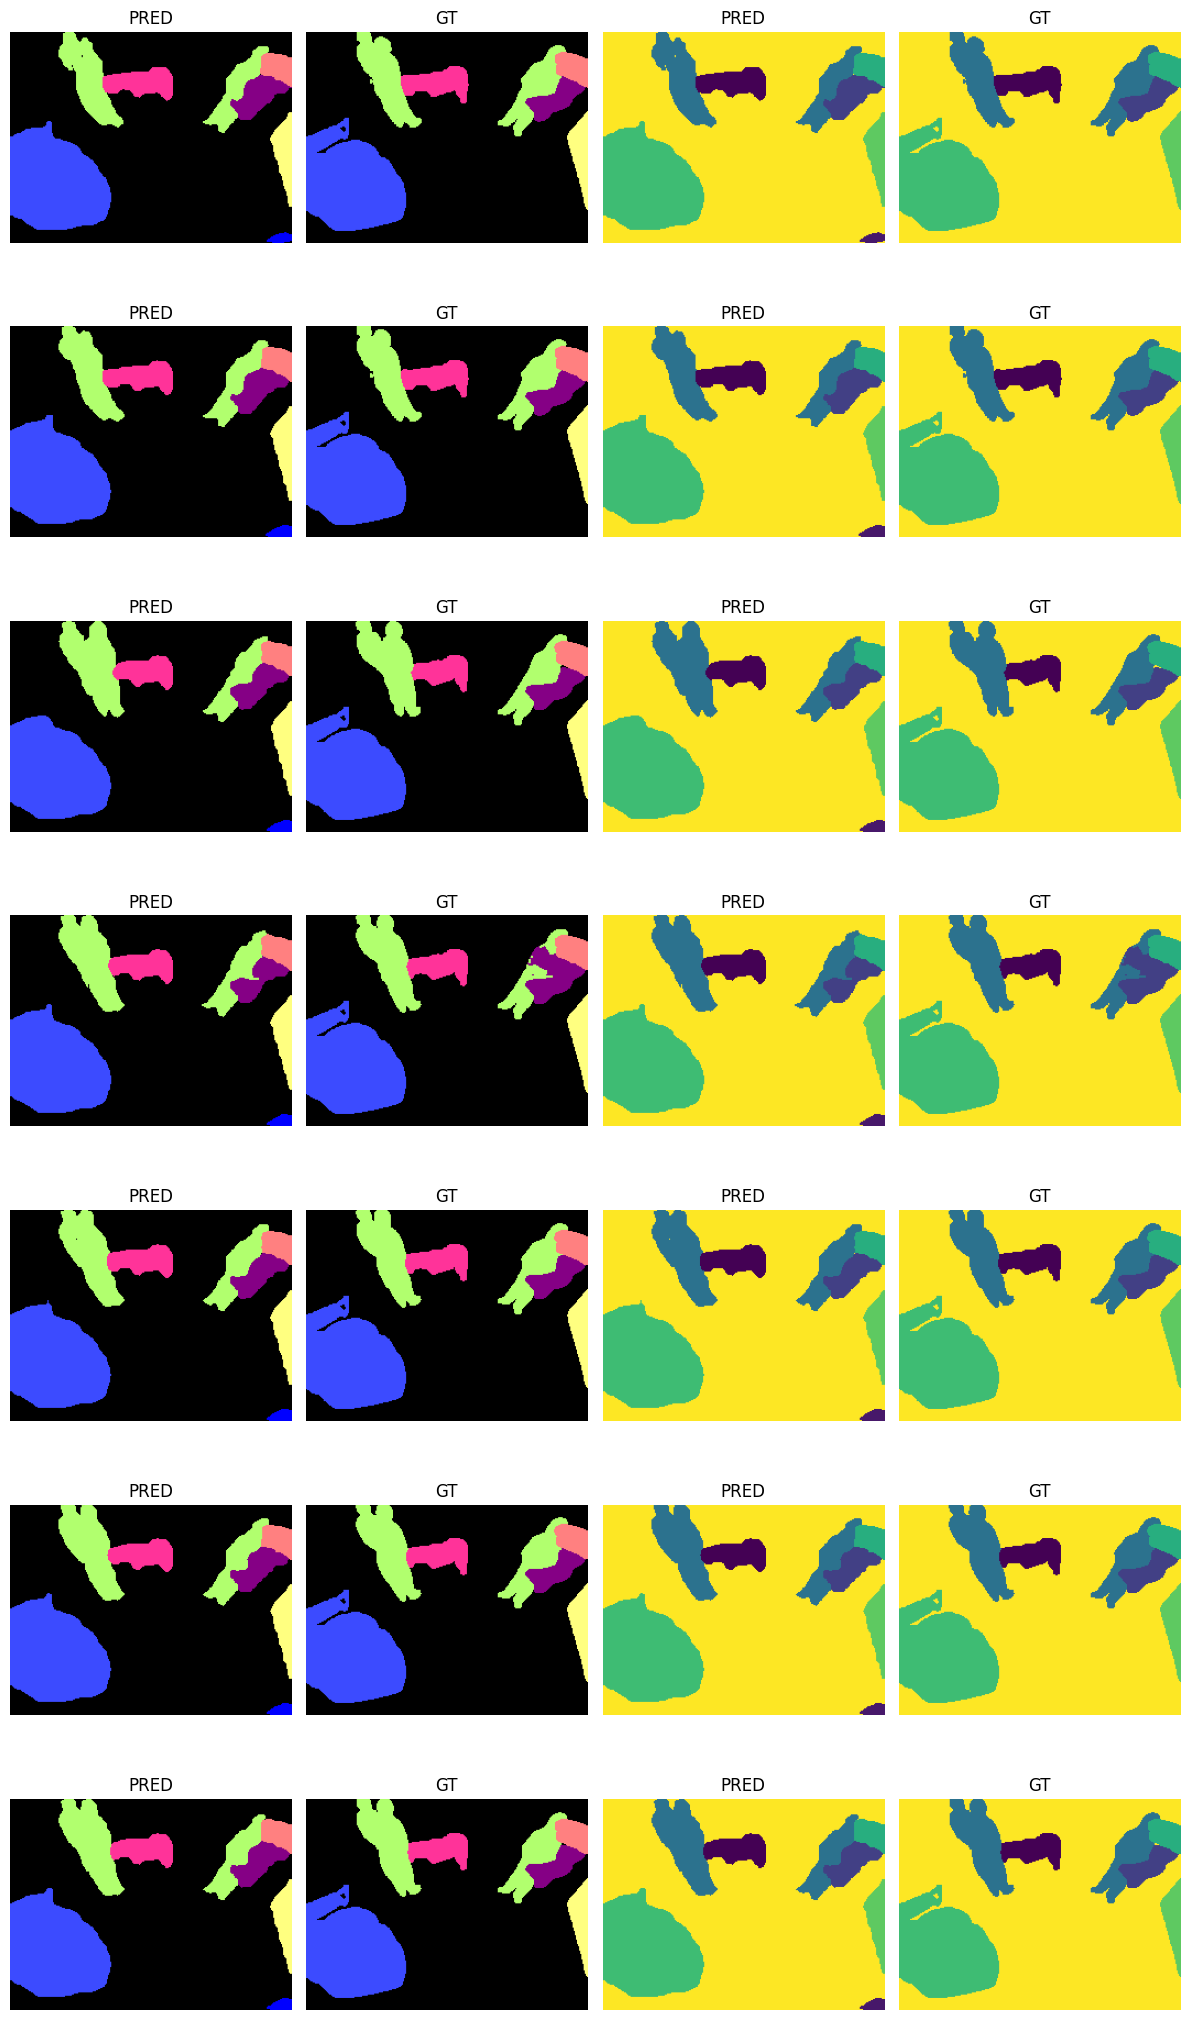

In [15]:
figsize = np.array([4, B]) * 3
fig, axs = plt.subplots(B, 4, figsize=figsize, )

for ii in range(B):
    axs[ii,0].imshow(pred_rgb_mask[ii])
    axs[ii,0].axis('off')
    axs[ii,0].set_title('PRED')

    axs[ii,1].imshow(gt_rgb_mask[ii])
    axs[ii,1].axis('off')
    axs[ii,1].set_title('GT')

    axs[ii,2].imshow(pred_seg_class_mask[ii, 0])
    axs[ii,2].axis('off')
    axs[ii,2].set_title('PRED')

    axs[ii,3].imshow(gt_seg_class_mask[ii, 0])
    axs[ii,3].axis('off')
    axs[ii,3].set_title('GT')

plt.tight_layout()
plt.show()

### Calculate Panoptic Quality (PQ)

In [16]:
# Stuff: 16, Things: 17 Instance labels: 0-15
background = 16
things = {LABEL_PROJECTION_MAP[idx]['label'] for idx in object_labels}
stuff = {background, background+1}  # Putting 17 does not change anything for the last value
print(f'Things: {things}\nStuff: {stuff}')

# Prepare stuff and things mask for prediction
preds = pred_seg_class_mask[:, 0, :, :, None]
stuff_things_mask = np.ones_like(preds) * (background + 1)  # 17 is the stuff label
pos_stuff = np.where(preds[:, :, :, 0] == background)  # Find where the background is
stuff_things_mask[pos_stuff[0], pos_stuff[1], pos_stuff[2], 0] = background  # Set the stuff label background
preds = np.concatenate((stuff_things_mask, preds), axis=3)

# Prepare stuff and things mask for GT
target = gt_seg_class_mask[:, 0, :, :, None]
stuff_things_mask_gt = np.ones_like(target) * (background + 1)  # 17 is the stuff label
pos_stuff = np.where(target[:, :, :, 0] == background)  # Find where the background is
stuff_things_mask_gt[pos_stuff[0], pos_stuff[1], pos_stuff[2], 0] = background  # Set the stuff label background
target = np.concatenate((stuff_things_mask_gt, target), axis=3)

# Convert to torch tensors
preds = torch.tensor(preds)
target = torch.tensor(target)

# Prepare panoptic quality metric
panoptic_quality = PanopticQuality(stuffs=stuff, things=things)
pq = panoptic_quality(preds, target)
print(f'Prediction: {preds.shape}, Target: {target.shape}')
print(f"PQ: {pq}")

Things: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Stuff: {16, 17}
Prediction: torch.Size([7, 192, 256, 2]), Target: torch.Size([7, 192, 256, 2])
PQ: 0.9445341868059975


# Prepare Masks on Image

batched_video_data_val.img_batch.shape = (N, B, C, H, W)  
masks_val.shape = (N, B*O, H, W)  
metadata.unique_objects_identifier = (N, B*O, 3) => [video_id, object_id, frame_id]  
obj_to_frame_idx = (N, B*O, 2) => [frame_id, video_id]  

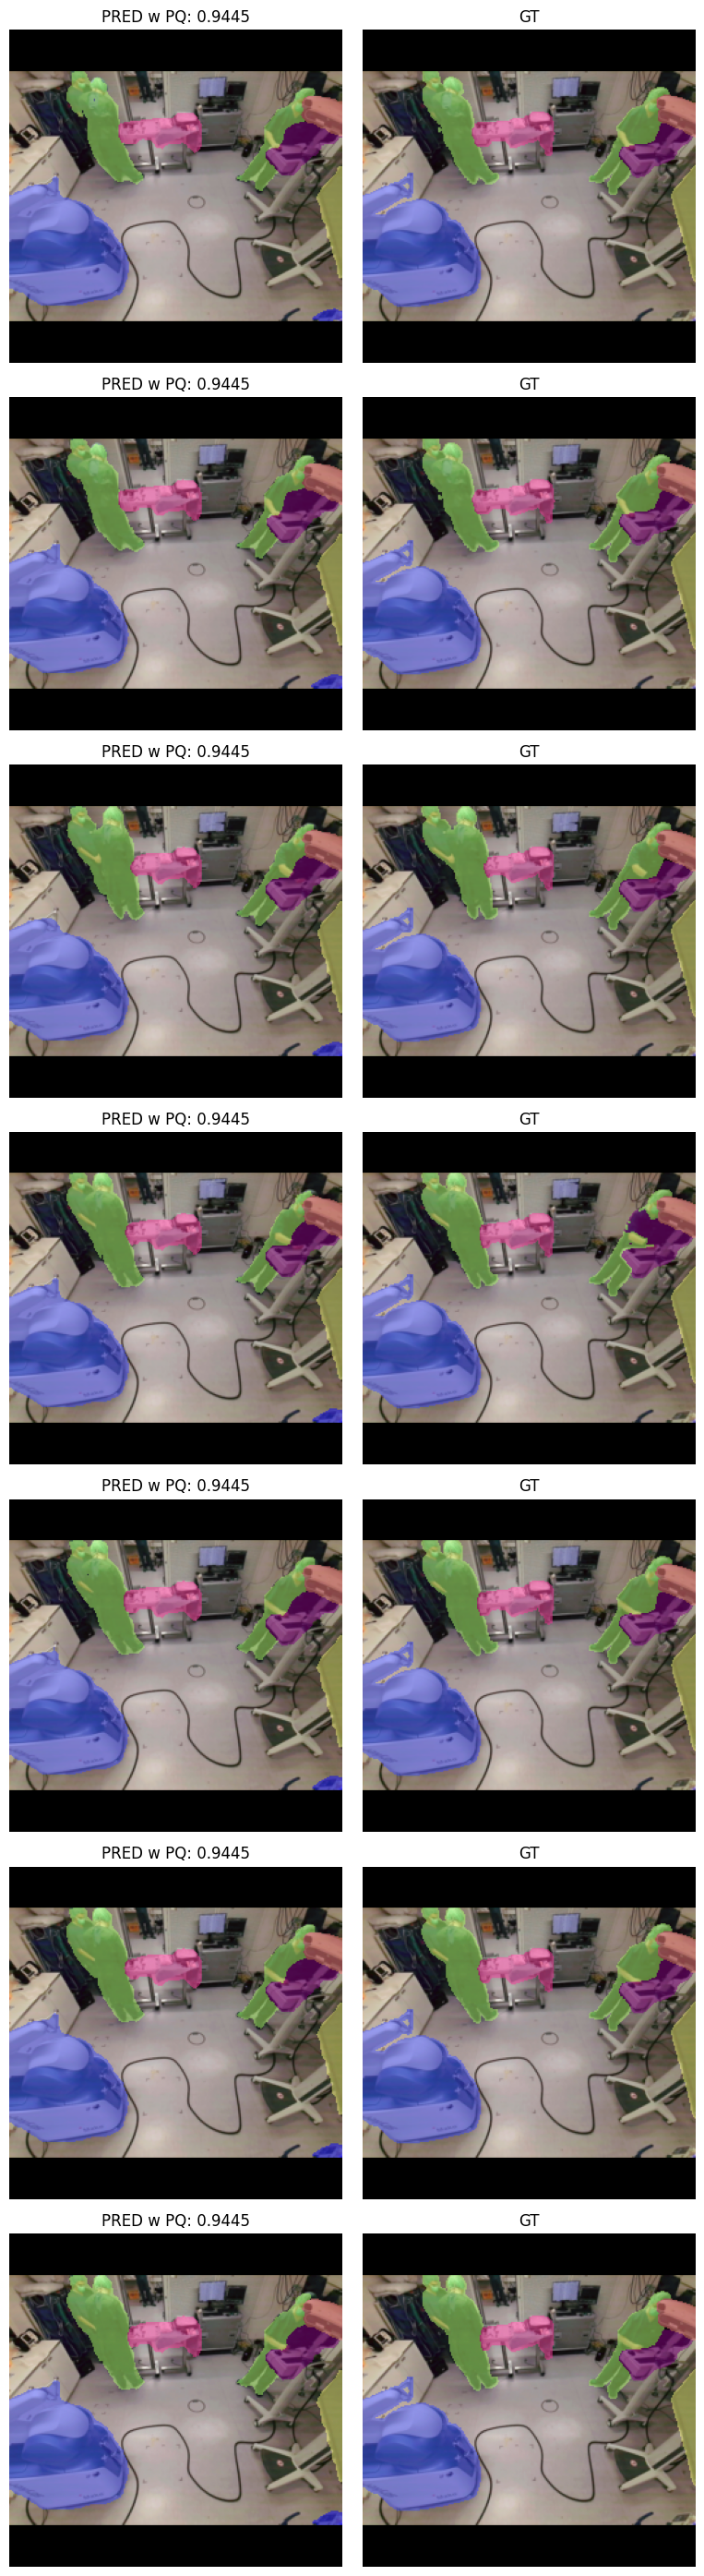

In [17]:
def get_color_map():
    color_map = []
    for k, v in LABEL_PROJECTION_MAP.items():
        if k > 7 and v['label'] == 6:
            continue
        r, g, b = v['color']
        color_map.append(sv.Color(r,g,b))
    color_map = sv.ColorPalette(colors=color_map)
    return color_map

# Get color map
color_map = get_color_map()

# GT Labels
gt_labels = batched_video_data_val.metadata.unique_objects_identifier[:,:,1]

# Create subplots
figsize = np.array([2, B]) * 4
fig, axs = plt.subplots(B, 2, figsize=figsize, )

for batch_idx in range(B):
    # Unnormalize the image
    image = batched_video_data_val.img_batch[batch_idx][0]
    unnormalized_image = toPILimage(revert_transform(image))

    # GT masks
    # Assumption: Batch size is 1, by batch index we mean frames
    gt_mask = masks_val[batch_idx, :, :, :].cpu().numpy()
    gt_class_id = gt_labels[batch_idx].cpu().numpy()
    empty_bboxes = np.array([[0, 0, 0, 0]] * len(gt_class_id))

    # Gt Annotated Frame 
    gt_detections = sv.Detections(xyxy=empty_bboxes, mask=gt_mask, class_id=gt_class_id)
    mask_annotator = sv.MaskAnnotator(color=color_map)
    gt_annotated_frame = mask_annotator.annotate(
        scene=unnormalized_image.copy(),
        detections=gt_detections
    )
    # sv.plot_image(gt_annotated_frame, size=(4,4)) if B <= 10 else None

    # Prediction masks
    pred_mask = (all_frame_outputs_val[batch_idx]['pred_masks_high_res'][0].sigmoid() > 0.5).cpu().numpy()
    # pred_class_ids = best_probs.indices.numpy().astype(np.int32)
    empty_bboxes = np.array([[0, 0, 0, 0]] * len(pred_class[0]))

    # Prediction Annotated Frame
    pred_detections = sv.Detections(xyxy=empty_bboxes, mask=pred_mask, class_id=pred_class[batch_idx])
    mask_annotator = sv.MaskAnnotator(color=color_map)
    pred_annotated_frame = mask_annotator.annotate(
        scene=unnormalized_image.copy(),
        detections=pred_detections
    )
    # sv.plot_image(pred_annotated_frame, size=(4,4)) if B <= 10 else None
    axs[batch_idx,0].imshow(pred_annotated_frame, )
    axs[batch_idx,0].axis('off')
    axs[batch_idx,0].set_title(f'PRED w PQ: {pq:.4f}')

    axs[batch_idx,1].imshow(gt_annotated_frame)
    axs[batch_idx,1].axis('off')
    axs[batch_idx,1].set_title('GT')

plt.tight_layout()
plt.show()
# plt.savefig('../temp/pred_gt.png', dpi=150)

In [18]:
# gt_mask = masks_val[batch_idx].cpu()
# black_placeholder = np.zeros_like(gt_mask[0])  # Black image placeholder

# # Create figure and subplots
# fig, axes = plt.subplots(4, 3, figsize=(10, 6))

# # First row (RGB, GT, Black Placeholder)
# axes[0, 0].imshow(unnormalized_image)
# axes[0, 0].set_title("RGB Image")

# axes[0, 1].imshow(black_placeholder, cmap='gray')
# axes[0, 1].set_title("Placeholder")

# axes[0, 2].imshow(gt_mask[0], cmap='gray')
# axes[0, 2].set_title("GT Mask 0")

# # Second row (GT gt_mask)
# axes[1, 0].imshow(gt_mask[1], cmap='gray')
# axes[1, 0].set_title("GT Mask 1")

# axes[1, 1].imshow(gt_mask[2], cmap='gray')
# axes[1, 1].set_title("GT Mask 2")

# axes[1, 2].imshow(gt_mask[3], cmap='gray')
# axes[1, 2].set_title("GT Mask 3")

# # Third row (GT gt_mask)
# axes[2, 0].imshow(gt_mask[4], cmap='gray')
# axes[2, 0].set_title("GT Mask 4")

# axes[2, 1].imshow(gt_mask[5], cmap='gray')
# axes[2, 1].set_title("GT Mask 5")

# axes[2, 2].imshow(gt_mask[6], cmap='gray')
# axes[2, 2].set_title("GT Mask 6")

# # Fourth row (GT gt_mask)
# axes[3, 0].imshow(gt_mask[7], cmap='gray')
# axes[3, 0].set_title("GT Mask 7")

# axes[3, 1].imshow(gt_mask[8], cmap='gray')
# axes[3, 1].set_title("GT Mask 8")

# axes[3, 2].imshow(gt_mask[9], cmap='gray')
# axes[3, 2].set_title("GT Mask 9")

# # Remove axes for a cleaner look
# for ax in axes.ravel():
#     ax.axis('off')

# # Show the plot
# plt.tight_layout()
# plt.show()

In [19]:
# black_placeholder = np.zeros_like(gt_mask[0])  # Black image placeholder
# pred_mask = (all_frame_outputs_val[batch_idx]['pred_masks'][0].sigmoid() > 0.5).bool().numpy()

# # Create figure and subplots
# fig, axes = plt.subplots(4, 3, figsize=(10, 6))

# # First row (RGB, GT, Black Placeholder)
# axes[0, 0].imshow(unnormalized_image)
# axes[0, 0].set_title("RGB Image")

# axes[0, 1].imshow(black_placeholder, cmap='gray')
# axes[0, 1].set_title("Placeholder")

# axes[0, 2].imshow(pred_mask[0], cmap='gray')
# axes[0, 2].set_title("Prediction 0")

# # Second row (Predictions)
# axes[1, 0].imshow(pred_mask[1], cmap='gray')
# axes[1, 0].set_title("Prediction 1")

# axes[1, 1].imshow(pred_mask[2], cmap='gray')
# axes[1, 1].set_title("Prediction 2")

# axes[1, 2].imshow(pred_mask[3], cmap='gray')
# axes[1, 2].set_title("Prediction 3")

# # Third row (Predictions)
# axes[2, 0].imshow(pred_mask[4], cmap='gray')
# axes[2, 0].set_title("Prediction 4")

# axes[2, 1].imshow(pred_mask[5], cmap='gray')
# axes[2, 1].set_title("Prediction 5")

# axes[2, 2].imshow(pred_mask[6], cmap='gray')
# axes[2, 2].set_title("Prediction 6")

# # Fourth row (Predictions)
# axes[3, 0].imshow(pred_mask[7], cmap='gray')
# axes[3, 0].set_title("Prediction 7")

# axes[3, 1].imshow(pred_mask[8], cmap='gray')
# axes[3, 1].set_title("Prediction 8")

# axes[3, 2].imshow(pred_mask[9], cmap='gray')
# axes[3, 2].set_title("Prediction 9")

# # Remove axes for a cleaner look
# for ax in axes.ravel():
#     ax.axis('off')

# # Show the plot
# plt.tight_layout()
# plt.show()